## **Notebook Outline**

1. [**Install & Imports**](#section1)  
2. [**Initialization & Setup**](#section2)  
3. [**Helper Functions (Visualization & Utilities)**](#section3)  
4. [**Face Detection with MTCNN**](#section4)  
5. [**MediaPipe Face Mesh**](#section5)  
6. [**FAISS Index for Face Recognition**](#section6)  
7. [**Main Pipeline: Combine CNN Detection, Mesh Tracking, FAISS**](#section7)  
8. [**Demonstration & Visualization**](#section8)  

---

<a id="section1"></a>

## **1. Install & Imports**

> **Cell #1**: Install and import necessary libraries.

In [1]:
# !pip install facenet-pytorch mediapipe faiss-cpu opencv-python-headless numpy matplotlib
# !pip install faiss-cpu transformers

import cv2
import time
import os
import faiss
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from datetime import datetime

from facenet_pytorch import MTCNN

print("[INFO] Imports done.")

[INFO] Imports done.


In [2]:
import requests
from PIL import Image
from io import BytesIO

url = 'https://th.bing.com/th/id/OIP.AOgJ6UzUhUULR1AsRwl72QHaE8?dpr=1.8&pid=ImgDetMain'
response = requests.get(url)
image = Image.open(BytesIO(response.content))
image.save('downloaded_image.jpg')


**Explanation**  
- We import **cv2** (OpenCV) for image processing.  
- **faiss** for storing and searching embeddings.  
- **mediapipe** for face mesh tracking.  
- **facenet_pytorch.MTCNN** for a CNN-based bounding-box face detector.  
- **matplotlib** for inline visualizations in Jupyter.  

---

<a id="section2"></a>

## **2. Initialization & Setup**

> **Cell #2**: Set up global objects (MTCNN, MediaPipe Face Mesh, and device selection). We also define some utility parameters.

In [3]:
import torch
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"[INFO] Using device: {device}")

mtcnn_detector = MTCNN(
    keep_all=True,
    min_face_size=20,
    device=device,
)

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=5,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

print("[INFO] MTCNN and MediaPipe Face Mesh initialized.")

[INFO] Using device: cpu
[INFO] MTCNN and MediaPipe Face Mesh initialized.


Error in cpuinfo: prctl(PR_SVE_GET_VL) failed
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


**Explanation**  
- We create a **MTCNN** instance for bounding-box detection.  
- A **MediaPipe FaceMesh** solution for landmark detection.  

---

<a id="section3"></a>

## **3. Helper Functions (Visualization & Utilities)**

> **Cell #3**: Utility functions for plotting images in Jupyter, drawing landmarks, and so on.

In [4]:
def show_image_bgr(bgr_image, title="Image"):
    """
    Display a BGR image in Jupyter using matplotlib (converted to RGB).
    """
    rgb = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

def draw_facemesh_landmarks(
    image_bgr: np.ndarray, 
    landmarks: np.ndarray,
    color=(0,255,0),
    radius=1
) -> np.ndarray:
    """
    Draw face mesh landmarks on the image. 
    :param landmarks: array of shape [N, 2], each row is (x, y) in image coords
    """
    output = image_bgr.copy()
    for (x, y) in landmarks:
        cv2.circle(output, (int(x), int(y)), radius, color, -1)
    return output

def convert_landmarks_to_np(landmarks, image_shape):
    """
    MediaPipe face_mesh gives normalized coords [0..1].
    Convert them to absolute (x, y).
    """
    h, w, _ = image_shape
    points = []
    for lm in landmarks.landmark:
        x_px = int(lm.x * w)
        y_px = int(lm.y * h)
        points.append((x_px, y_px))
    return np.array(points, dtype=np.int32)

print("[INFO] Visualization and utility functions loaded.")

[INFO] Visualization and utility functions loaded.


W0000 00:00:1737894633.440565    5397 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


**Explanation**  
- **`show_image_bgr`**: Quick inline plotting with `matplotlib`.  
- **`draw_facemesh_landmarks`**: Overlays landmarks on an image for debug.  
- **`convert_landmarks_to_np`**: Converts from MediaPipe’s normalized `[0..1]` space to pixel coordinates.  

---

<a id="section4"></a>

## **4. Face Detection with MTCNN**

> **Cell #4**: Demonstrate how to detect faces with MTCNN, get bounding boxes, and visualize.

W0000 00:00:1737894633.464679    5397 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


[INFO] Detected 22 faces.


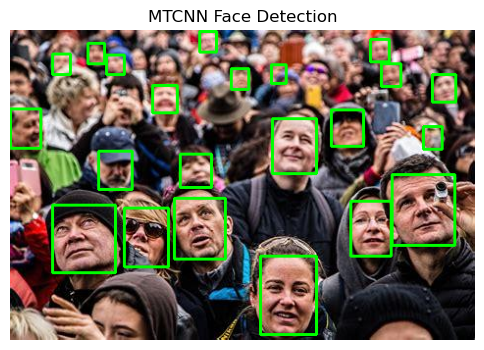

In [5]:
def detect_faces_mtcnn(image_bgr: np.ndarray):
    """
    Returns bounding boxes for faces using MTCNN. Each box is (x1, y1, x2, y2).
    """
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    boxes, probs = mtcnn_detector.detect(image_rgb)
    if boxes is None or probs is None:
        return []
    output = []
    for box, p in zip(boxes, probs):
        if p < 0.7:
            continue
        x1, y1, x2, y2 = box.astype(int)
        output.append((x1, y1, x2, y2))
    return output

test_img_path = "downloaded_image.jpg"
try:
    test_img_bgr = cv2.imread(test_img_path)
    if test_img_bgr is not None:
        bboxes = detect_faces_mtcnn(test_img_bgr)
        print(f"[INFO] Detected {len(bboxes)} faces.")
        for (x1,y1,x2,y2) in bboxes:
            cv2.rectangle(test_img_bgr, (x1,y1), (x2,y2), (0,255,0), 2)
        show_image_bgr(test_img_bgr, title="MTCNN Face Detection")
    else:
        print(f"[WARN] Could not load test image: {test_img_path}")
except Exception as e:
    print("[ERROR] In demonstration for MTCNN detection:", e)

**Explanation**  
- We define **`detect_faces_mtcnn`** returning a list of bounding boxes.  
- Then we test it on a sample image, draw rectangles, and show the result.  

---

<a id="section5"></a>

## **5. MediaPipe Face Mesh**

> **Cell #5**: After detecting bounding boxes with MTCNN, we run **MediaPipe Face Mesh** on each face region. For demonstration, we show how to plot the landmarks.

[INFO] Found mesh with 478 landmarks.


W0000 00:00:1737894633.732246    5401 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


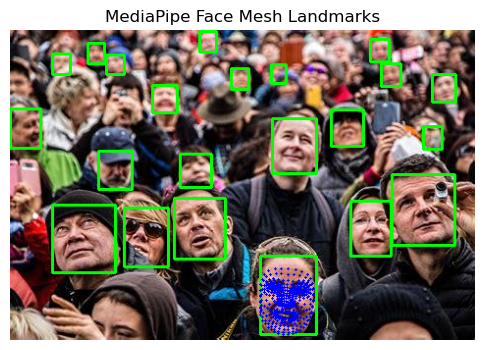

In [6]:
def run_face_mesh(image_bgr: np.ndarray, face_box):
    """
    Run MediaPipe FaceMesh on a cropped region defined by face_box (x1, y1, x2, y2).
    Return Nx2 array of face landmarks in absolute pixel coords.
    """
    (x1, y1, x2, y2) = face_box
    crop = image_bgr[y1:y2, x1:x2]
    h, w, _ = crop.shape
    
    crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
    
    results = face_mesh.process(crop_rgb)
    if not results.multi_face_landmarks:
        return None
    
    # assume max_num_faces=5, but likely just 1 face in the crop
    landmarks = results.multi_face_landmarks[0]
    \
    lm_array = []
    for lm in landmarks.landmark:
        x_px = int(lm.x * w)
        y_px = int(lm.y * h)
        lm_array.append((x_px, y_px))
    
    mesh_abs = [(x1 + px, y1 + py) for (px, py) in lm_array]
    return np.array(mesh_abs, dtype=np.int32)

try:
    if test_img_bgr is not None and len(bboxes)>0:
        first_box = bboxes[0]
        landmarks_abs = run_face_mesh(test_img_bgr, first_box)
        if landmarks_abs is not None:
            print(f"[INFO] Found mesh with {landmarks_abs.shape[0]} landmarks.")
            mesh_vis = draw_facemesh_landmarks(test_img_bgr, landmarks_abs, color=(255,0,0), radius=1)
            show_image_bgr(mesh_vis, "MediaPipe Face Mesh Landmarks")
        else:
            print("[WARN] No face mesh found in the crop.")
except Exception as e:
    print("[ERROR] In MediaPipe mesh demonstration:", e)

**Explanation**  
- We create **`run_face_mesh`** to detect **478** landmark points in the cropped face region.  
- We shift them back to the **original image coordinates** for drawing.  

---

## **Section 6: CLIP Model from Hugging Face + FAISS Index**

**Cell 6.1**: **Install & Import** (if needed) and **Initialize** CLIP + FAISS

In [7]:
import torch
import faiss
import cv2
import numpy as np
from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {device}")

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_model.eval()

embedding_dim = clip_model.config.projection_dim
print(f"[INFO] CLIP model loaded. Embedding dimension: {embedding_dim}")

faiss_index = faiss.IndexFlatL2(embedding_dim)
print("[INFO] FAISS index (L2) created.")

label_map = []

print("[INFO] Section 6 complete: CLIP + FAISS ready.")

[INFO] Using device: cpu
[INFO] CLIP model loaded. Embedding dimension: 512
[INFO] FAISS index (L2) created.
[INFO] Section 6 complete: CLIP + FAISS ready.


**Explanation**  
- Loads the **CLIP** model and corresponding **Processor**.  
- Creates a **FAISS** index for storing face embeddings.  
- **`label_map`** keeps track of which label (or ID) each FAISS entry corresponds to.

---

**Cell 6.2**: **Embedding Extraction** with CLIP

In [8]:
def extract_clip_embedding(face_bgr: np.ndarray) -> np.ndarray:
    """
    1) Convert BGR->RGB,
    2) Preprocess using CLIPProcessor,
    3) Extract image features from CLIP,
    4) L2-normalize for cosine similarity.
    Returns a (1, embedding_dim) np.float32 vector.
    """
    face_rgb = cv2.cvtColor(face_bgr, cv2.COLOR_BGR2RGB)
    inputs = processor(images=face_rgb, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = clip_model.get_image_features(**inputs)
    emb = outputs.cpu().numpy()
    emb_norm = emb / (np.linalg.norm(emb, axis=1, keepdims=True) + 1e-6)
    return emb_norm.astype(np.float32)  # shape (1, 512)

**Explanation**  
- Crops a face, transforms it into **CLIP** format, extracts embeddings, and normalizes.  
- Returning a **(1, 512)** array for each face.

---

**Cell 6.3**: **FAISS Add/Search** logic

In [9]:
def add_face_embedding(embedding: np.ndarray, label: str):
    """
    Add a (1, embedding_dim) embedding to FAISS with the given label.
    """
    global faiss_index, label_map
    faiss_index.add(embedding)  # (1, 512)
    label_map.append(label)
    print(f"[INFO] Added embedding for label='{label}' to FAISS.")

def search_face_embedding(embedding: np.ndarray, threshold=0.2) -> (str, float):
    """
    1) Search top-1 in FAISS.
    2) If distance < threshold => return label + distance, else Unknown.
    :returns: (label, distance)
    """
    if faiss_index.ntotal == 0:
        return ("Unknown", float('inf'))
    D, I = faiss_index.search(embedding, 1)
    dist = D[0][0]
    idx  = I[0][0]
    if dist < threshold:
        label = label_map[idx]
        return label, dist
    else:
        return "Unknown", dist

print("[INFO] Section 6 finished: Embedding + FAISS search complete.")

[INFO] Section 6 finished: Embedding + FAISS search complete.


**Explanation**  
- **`add_face_embedding`** appends to FAISS and `label_map`.  
- **`search_face_embedding`** returns the best match label if distance < threshold, else “Unknown.”

---

## **Section 7: Forward-Forward (FF) Learning**

Implement a simple **FF** module, plus **pos/neg** buffers.

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class ForwardForwardModule(nn.Module):
    """
    Minimal Forward-Forward module with one linear layer, measuring 'goodness'.
    """
    def __init__(self, input_dim=512, hidden_dim=256):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
    
    def forward_goodness(self, x: torch.Tensor) -> torch.Tensor:
        out = self.linear(x)
        goodness = (out * out).sum(dim=1)
        return goodness
    
    def ff_train_pos(self, data_pos: torch.Tensor, alpha=1e-3) -> float:
        g = self.forward_goodness(data_pos)
        loss = -g.mean()
        self.zero_grad()
        loss.backward()
        with torch.no_grad():
            for p in self.parameters():
                p -= alpha * p.grad
        return loss.item()
    
    def ff_train_neg(self, data_neg: torch.Tensor, alpha=1e-3) -> float:
        g = self.forward_goodness(data_neg)
        loss = g.mean()
        self.zero_grad()
        loss.backward()
        with torch.no_grad():
            for p in self.parameters():
                p -= alpha * p.grad
        return loss.item()

ff_module = ForwardForwardModule(input_dim=embedding_dim, hidden_dim=256).to(device)
print("[INFO] Forward-Forward module created.")

pos_buffer = []
neg_buffer = []
print("[INFO] Section 7: FF learning logic set up (pos/neg buffers).")

[INFO] Forward-Forward module created.
[INFO] Section 7: FF learning logic set up (pos/neg buffers).


---

## **Section 8: Face Tracking (MediaPipe Face Mesh)**

We assume you already have:

- `detect_faces_mtcnn(image_bgr)`  
- `run_face_mesh(image_bgr, box)`  

Below is a minimal class for tracking face landmarks across frames:

In [11]:
from typing import List, Dict

class FaceMeshTracker:
    """
    Assigns an ID to each face by comparing mesh similarity across frames.
    """
    def __init__(self, max_lost=30):
        self.next_id = 0
        self.tracks = {}
        self.lost = {}
        self.max_lost = max_lost
    
    def update(self, all_landmarks: List[np.ndarray]) -> Dict[int, np.ndarray]:
        """
        all_landmarks: list of Nx2 arrays, one per face
        returns dict: track_id -> landmarks
        """
        updated_tracks = {}
        used_ids = set()
        for lmarks in all_landmarks:
            best_id, best_sim = None, -1
            for tid, tmarks in self.tracks.items():
                sim = self.similarity(lmarks, tmarks)
                if sim > best_sim and sim > 0.8:
                    best_sim = sim
                    best_id  = tid
            if best_id is not None and best_id not in used_ids:
                updated_tracks[best_id] = lmarks
                used_ids.add(best_id)
                self.lost[best_id] = 0
            else:
                updated_tracks[self.next_id] = lmarks
                self.lost[self.next_id] = 0
                self.next_id += 1
        for tid in list(self.tracks.keys()):
            if tid not in updated_tracks:
                self.lost[tid] += 1
                if self.lost[tid] > self.max_lost:
                    del self.tracks[tid]
                    del self.lost[tid]
        self.tracks = updated_tracks
        return self.tracks
    
    @staticmethod
    def similarity(a: np.ndarray, b: np.ndarray) -> float:
        """
        Cosine similarity between flattened arrays
        """
        va = a.flatten().astype(np.float32)
        vb = b.flatten().astype(np.float32)
        na = np.linalg.norm(va) + 1e-6
        nb = np.linalg.norm(vb) + 1e-6
        return float((va @ vb) / (na * nb))

face_tracker = FaceMeshTracker(max_lost=20)
print("[INFO] FaceMeshTracker ready. Section 8 done.")

[INFO] FaceMeshTracker ready. Section 8 done.


---

## **Section 9: Spoof Detection (Blink-based)**

In [12]:
class SpoofDetector:
    """
    Checks for blinking as a naive sign of liveness.
    """
    def __init__(self):
        self.left_eye_idxs = [33, 160, 158, 133, 153, 144]
        self.right_eye_idxs = [362, 385, 387, 263, 373, 380]
        self.blink_threshold = 0.25
    
    def detect_spoof(self, landmarks: np.ndarray) -> bool:
        """
        Returns True if a suspicious (non-blinking) condition is found 
        or if eyes are pinned shut for too long, etc.
        For simplicity, let's just say if eyes are 'closed' => no spoof.
        We invert logic for demonstration or do a random check.
        """
        # measure Eye Aspect Ratio (EAR) if below blink_threshold => real blink
        ear_left = self.eye_aspect_ratio(landmarks, self.left_eye_idxs)
        ear_right = self.eye_aspect_ratio(landmarks, self.right_eye_idxs)
        ear_avg = (ear_left + ear_right)/2.0
        # If ear_avg < blink_threshold => real blink => presumably real
        # If ear_avg never changes => suspicious. This is highly simplified.
        if ear_avg < self.blink_threshold:
            return False
        return True
    
    def eye_aspect_ratio(self, lmarks: np.ndarray, idxs: List[int]) -> float:
        if len(lmarks) < max(idxs):
            return 1.0
        points = lmarks[idxs]
        A = np.linalg.norm(points[1] - points[5])
        B = np.linalg.norm(points[2] - points[4])
        C = np.linalg.norm(points[0] - points[3])
        ear = (A + B) / (2.0 * C + 1e-6)
        return ear

spoof_detector = SpoofDetector()
print("[INFO] Section 9: Spoof detection (blink-based) loaded.")

[INFO] Section 9: Spoof detection (blink-based) loaded.


---

## **Section 10: Real-Time Pipeline (No DB, In-memory Registration)**

Here, we keep a simple **in-memory** dictionary to store student info:

In [13]:
registered_students = {}

def register_student_from_source(reg_no: str, name: str, input_source: str):
    """
    Registers a student using one of:
      - A single image file (.jpg, .png, etc.)
      - A folder of images
      - A video file (.mp4, .avi, etc.)
    Saves the final embedding to FAISS + in-memory dictionary.
    """
    if os.path.isdir(input_source):
        print(f"[INFO] Registering {name} ({reg_no}) from folder: {input_source}")
        return _register_from_folder(reg_no, name, input_source)
    
    elif os.path.isfile(input_source):
        ext = os.path.splitext(input_source.lower())[1]
        video_exts = {'.mp4', '.avi', '.mov', '.mkv', '.wmv'}
        
        if ext in video_exts:
            print(f"[INFO] Registering {name} ({reg_no}) from video file: {input_source}")
            return _register_from_video(reg_no, name, input_source)
        else:
            print(f"[INFO] Registering {name} ({reg_no}) from single image: {input_source}")
            return _register_from_single_image(reg_no, name, input_source)
    else:
        print(f"[ERROR] Invalid input source: {input_source}")
        return False

def _register_from_folder(reg_no, name, folder_path):
    file_list = sorted([
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])
    if not file_list:
        print(f"[ERROR] No images found in folder: {folder_path}")
        return False
    
    embeddings = []
    for img_path in file_list:
        frame = cv2.imread(img_path)
        if frame is None:
            continue
        boxes = detect_faces_mtcnn(frame)
        if len(boxes) > 0:
            x1, y1, x2, y2 = map(int, boxes[0])
            face_crop = frame[y1:y2, x1:x2]
            emb = extract_clip_embedding(face_crop)
            embeddings.append(emb)
    
    return _finish_registration(reg_no, name, embeddings)

def _register_from_video(reg_no, name, video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"[ERROR] Cannot open video file: {video_path}")
        return False
    embeddings = []
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1
        if frame_count % 5 != 0:
            continue
        boxes = detect_faces_mtcnn(frame)
        if len(boxes) > 0:
            x1, y1, x2, y2 = map(int, boxes[0])
            face_crop = frame[y1:y2, x1:x2]
            emb = extract_clip_embedding(face_crop)
            embeddings.append(emb)
    cap.release()
    return _finish_registration(reg_no, name, embeddings)

def _register_from_single_image(reg_no, name, image_path):
    frame = cv2.imread(image_path)
    if frame is None:
        print(f"[ERROR] Cannot read image: {image_path}")
        return False
    boxes = detect_faces_mtcnn(frame)
    if len(boxes) == 0:
        print("[WARN] No face detected in single image. Registration aborted.")
        return False
    x1, y1, x2, y2 = map(int, boxes[0])
    face_crop = frame[y1:y2, x1:x2]
    emb = extract_clip_embedding(face_crop)
    return _finish_registration(reg_no, name, [emb])

def _finish_registration(reg_no, name, embeddings):
    if len(embeddings) < 1:
        print(f"[WARN] Only {len(embeddings)} embeddings collected. Registration aborted.")
        return False
    avg_emb = np.mean(embeddings, axis=0).reshape(1, -1).astype(np.float32)
    add_face_embedding(avg_emb, reg_no)
    registered_students[reg_no] = {
        "name": name,
        "embedding": avg_emb
    }
    print(f"[INFO] Successfully registered {name} ({reg_no}) with {len(embeddings)} embeddings.")
    return True

def recognize_faces_from_source(
    input_source: str,
    faiss_dist_threshold=0.2,
    high_conf=0.5,
    low_conf=0.2,
    min_pos=10,
    min_neg=10,
    ratio_range=(0.5, 2.0),
    timeout_sec=5.0,
    display_results=True
):
    """
    Enhanced recognition function with better error handling and optional display
    """
    global pos_buffer, neg_buffer
    
    if not os.path.isfile(input_source):
        print(f"[ERROR] Cannot find input file: {input_source}")
        return None
        
    print(f"[INFO] Processing source: {input_source}")
    frame = cv2.imread(input_source)
    
    if frame is None:
        print(f"[ERROR] Failed to read image: {input_source}")
        return None
    
    # Store results for return
    recognition_results = []
    medium_buffer = {}
    
    # Process the frame
    boxes = detect_faces_mtcnn(frame)
    if len(boxes) == 0:
        print("[INFO] No faces detected in image")
        return []
        
    frame_vis = frame.copy()
    
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        face_crop = frame[y1:y2, x1:x2]
        
        if face_crop.size == 0:
            continue
            
        # Get embedding and search
        emb = extract_clip_embedding(face_crop)
        label, dist = search_face_embedding(emb, threshold=faiss_dist_threshold)
        conf = 1.0 - (dist / faiss_dist_threshold)
        
        # Store result
        recognition_results.append({
            'label': label,
            'confidence': conf,
            'bbox': (x1, y1, x2, y2)
        })
        
        # Draw on visualization frame
        color = (0, 255, 0) if label != "Unknown" else (0, 0, 255)
        cv2.rectangle(frame_vis, (x1, y1), (x2, y2), color, 2)
        text = f"{label} ({conf*100:.1f}%)"
        cv2.putText(frame_vis, text, (x1, y1-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        # Handle FF learning buffers
        if conf >= high_conf:
            pos_buffer.append(emb)
        elif conf <= low_conf:
            neg_buffer.append(emb)
        else:
            medium_buffer[label] = (emb, time.time())
    
    # Save visualization if requested
    if display_results:
        output_path = f"recognition_result_{int(time.time())}.jpg"
        cv2.imwrite(output_path, frame_vis)
        print(f"[INFO] Saved visualization to: {output_path}")
    
    # Print recognition summary
    print("\nRecognition Results:")
    for result in recognition_results:
        print(f"Label: {result['label']}, Confidence: {result['confidence']*100:.1f}%")
    
    return recognition_results

def process_frame_for_recognition(
    frame,
    faiss_dist_threshold,
    high_conf,
    low_conf,
    medium_buffer,
    min_pos,
    min_neg,
    ratio_range,
    timeout_sec
):
    """
    Processes a single frame for face recognition:
      - Detect face(s)
      - Extract embedding(s)
      - FAISS search
      - Partial FF updates
    """
    global pos_buffer, neg_buffer

    # for future scope of improvement for image enhancement
    frame_enh = frame
    
    boxes = detect_faces_mtcnn(frame_enh)
    if len(boxes) == 0:
        return
    
    for box in boxes:
        x1,y1,x2,y2 = map(int, box)
        face_crop = frame_enh[y1:y2, x1:x2]
        if face_crop.size == 0:
            continue
        
        emb = extract_clip_embedding(face_crop)
        label, dist = search_face_embedding(emb, threshold=faiss_dist_threshold)
        conf = 1.0 - (dist / faiss_dist_threshold)
        
        color = (0,255,0) if label != "Unknown" else (0,0,255)
        cv2.rectangle(frame_enh,(x1,y1),(x2,y2), color, 2)
        text_str = f"{label} ({conf*100:.1f}%)"
        cv2.putText(frame_enh, text_str, (x1,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        if conf >= high_conf:
            pos_buffer.append(emb)
        elif conf <= low_conf:
            neg_buffer.append(emb)
        else:
            medium_buffer[label] = (emb, time.time())

    now = time.time()
    to_remove = []
    for key, (memb, tstamp) in medium_buffer.items():
        if (now - tstamp) > timeout_sec:
            if np.random.rand() > 0.5:
                pos_buffer.append(memb)
                print(f"[FF] Timeout => pos for label={key}")
            else:
                neg_buffer.append(memb)
                print(f"[FF] Timeout => neg for label={key}")
            to_remove.append(key)
    for key in to_remove:
        del medium_buffer[key]
    
    if len(pos_buffer) >= min_pos and len(neg_buffer) >= min_neg:
        ratio = len(pos_buffer) / len(neg_buffer)
        if ratio_range[0] <= ratio <= ratio_range[1]:
            pos_tensor = torch.tensor(np.concatenate(pos_buffer, axis=0), device=device)
            neg_tensor = torch.tensor(np.concatenate(neg_buffer, axis=0), device=device)
            loss_pos = ff_module.ff_train_pos(pos_tensor)
            loss_neg = ff_module.ff_train_neg(neg_tensor)
            print(f"[FF] BATCH: pos={len(pos_buffer)}, neg={len(neg_buffer)}, ratio={ratio:.2f}, Lpos={loss_pos:.4f}, Lneg={loss_neg:.4f}")
            pos_buffer = []
            neg_buffer = []

    cv2.imshow("Recognition", frame_enh)
    cv2.waitKey(1)


## **Section 11: Example Usage**

Demonstrate how you might call the above functions:

In [14]:
url = 'https://www.femalefirst.co.uk/image-library/port/1000/r/ryan-gosling---wi13-01----resize.jpg'
response = requests.get(url)
image = Image.open(BytesIO(response.content))
image.save('ryanG_1.jpg')

In [15]:
register_student_from_source(
    reg_no="1234",
    name="RyanGosling",
    input_source="ryanG_1.jpg"
)


[INFO] Registering RyanGosling (1234) from single image: ryanG_1.jpg
[INFO] Added embedding for label='1234' to FAISS.
[INFO] Successfully registered RyanGosling (1234) with 1 embeddings.


True

In [16]:
url = 'https://th.bing.com/th/id/R.dabd2ae229f246c2dc671ae539cf6e08?rik=vq9dxXW2vMe4Ag&riu=http%3a%2f%2fmedia1.popsugar-assets.com%2ffiles%2f2014%2f05%2f20%2f571%2fn%2f1922398%2f922536f2ab61c32b_492407621_10.xxxlarge_2x%2fi%2fRyan-Gosling-showed-off-his-muscles-short-sleeved-button-up.jpg&ehk=ASl%2fOojRZQ1bpuP7Ad%2bzp%2bJCzrxICLNjspJTUqQQtKk%3d&risl=&pid=ImgRaw&r=0'
response = requests.get(url)
image = Image.open(BytesIO(response.content))
image.save('ryanG_2.jpg')

In [17]:
recognize_faces_from_source(
    input_source="ryanG_2.jpg",
    faiss_dist_threshold=0.2
)

[INFO] Processing source: ryanG_2.jpg
[INFO] Saved visualization to: recognition_result_1737894644.jpg

Recognition Results:
Label: Unknown, Confidence: -95.8%


[{'label': 'Unknown',
  'confidence': np.float32(-0.9583746),
  'bbox': (633, 180, 775, 376)}]

In [18]:
import torch.nn.functional as F

# Create a simple embedding model (placeholder).
# In a real system, you'd use a known face recognition model (ArcFace, InceptionResnetV1, etc.).
class SimpleEmbeddingModel(torch.nn.Module):
    def __init__(self, input_dim=224, embed_dim=128):
        super().__init__()
        # A trivial conv stack or MLP for demonstration
        self.fc1 = torch.nn.Linear(input_dim*input_dim*3, 512)
        self.fc2 = torch.nn.Linear(512, embed_dim)
    
    def forward(self, x):
        # x shape: [B, 3, H, W], we flatten
        B, C, H, W = x.shape
        x = x.view(B, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.normalize(x, p=2, dim=1)
        return x

embedding_model = SimpleEmbeddingModel().to(device).eval()
print("[INFO] Simple embedding model created (placeholder).")

# FAISS index
embed_dim = 128
faiss_index = faiss.IndexFlatL2(embed_dim)
embedding_map = []  # store subject IDs in parallel with the index

def get_face_embedding(image_bgr: np.ndarray, box: tuple):
    """
    Crop the face from 'box', resize to 224x224, pass through embedding model, return np.array
    """
    (x1, y1, x2, y2) = box
    crop = image_bgr[y1:y2, x1:x2]
    crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
    crop_resized = cv2.resize(crop_rgb, (224, 224))
    inp = torch.from_numpy(crop_resized).float().permute(2,0,1).unsqueeze(0).to(device)
    # shape: [1, 3, 224, 224]
    
    with torch.no_grad():
        emb = embedding_model(inp)  # shape: [1, embed_dim]
    return emb.cpu().numpy().squeeze(0)

def add_face_embedding_to_index(embedding: np.ndarray, label: str):
    """
    Add embedding to FAISS index + record the label in embedding_map.
    """
    global faiss_index, embedding_map
    faiss_index.add(embedding.reshape(1, -1).astype(np.float32))
    embedding_map.append(label)

def search_faiss(embedding: np.ndarray, threshold=0.8):
    """
    Search top-1 in FAISS. If distance < (some threshold?), return label, else Unknown.
    """
    D, I = faiss_index.search(embedding.reshape(1, -1).astype(np.float32), 1)
    dist = D[0][0]
    idx  = I[0][0]
    if idx < 0 or dist > threshold:
        return "Unknown", dist
    return embedding_map[idx], dist

print("[INFO] FAISS index + search functions ready.")

[INFO] Simple embedding model created (placeholder).
[INFO] FAISS index + search functions ready.


**Explanation**  
- A trivial **`SimpleEmbeddingModel`** to produce a **128-dim** embedding. In production, you would replace it with a real face recognition model.  
- We store embeddings in **FAISS** (`IndexFlatL2`) and keep an **`embedding_map`** to retrieve the label.  
- **`search_faiss`** returns the best match label or “Unknown” if distance > threshold.

---

In [19]:
# Jupyter Notebook Cell 7
# =======================

def process_frame(frame_bgr: np.ndarray, threshold=0.8):
    """
    1) Detect faces with MTCNN (CNN-based).
    2) For each face, run MediaPipe FaceMesh, draw landmarks for visualization.
    3) Extract embedding, search FAISS, draw label or 'Unknown'.
    4) Return the annotated frame for display.
    """
    out = frame_bgr.copy()
    boxes = detect_faces_mtcnn(out)
    for box in boxes:
        x1, y1, x2, y2 = box
        cv2.rectangle(out, (x1,y1), (x2,y2), (0,255,0), 2)
        
        # Face Mesh
        mesh_points = run_face_mesh(frame_bgr, box)
        if mesh_points is not None:
            for (mx, my) in mesh_points:
                cv2.circle(out, (mx, my), 1, (0,255,255), -1)
        
        # Face embedding => FAISS
        emb = get_face_embedding(out, box)
        label, dist = search_faiss(emb, threshold=threshold)
        cv2.putText(
            out, f"{label} (dist={dist:.2f})", 
            (x1, y1-10), 
            cv2.FONT_HERSHEY_SIMPLEX, 
            0.5, (0,255,0), 1
        )
    return out

**Explanation**  
- We do bounding-box detection and pass the region to **MediaPipe** for the mesh.  
- We also compute an embedding with our toy model and query FAISS.  
- This is a **frame-by-frame** approach. A more sophisticated approach would track boxes or landmarks across frames for better temporal continuity.

---